# P1. Exploration

## 1. Description Générale

En utilisant DBeaver et les paramètres de connexion donnés par ailleurs, faire une description détaillée de la base de données fournie. Présenter notamment le diagramme entité - relation (ERD) et les différentes caractéristiques des tables de la base.  Quelles types de renseignement peut-on tirer de cette base de données ?   

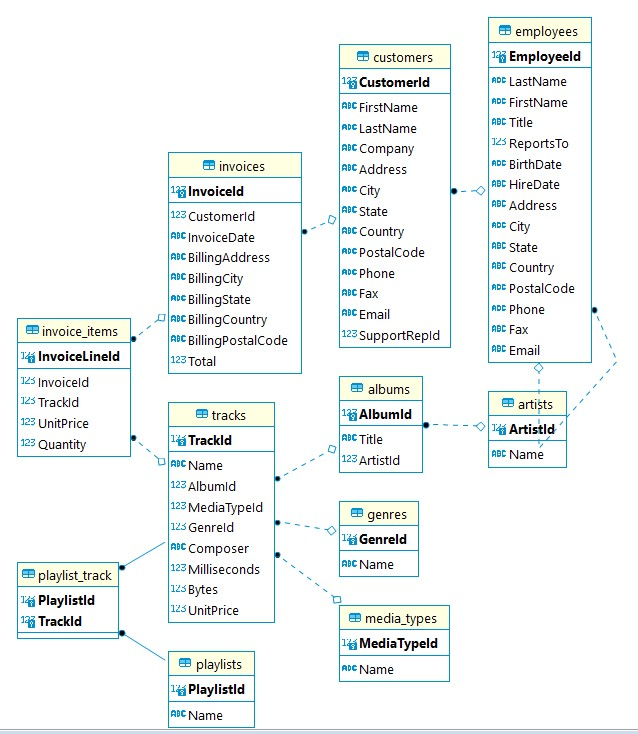

In [1]:
from IPython.display import Image
Image(filename='ref_table.jpg') 

Il y a 10 tables, sont indiqués les clés primaires:
- employees: EmployeeId
- customers: CustomerId
- invoices: InvoicesId
- invoice_items: InvoicelineId
- tracks: TrackId
- playslist_track: PlaylistId + TrackId
- playlists: playlistId
- albums: AlbumId
- artists: Artists.Id
- genres: GenreId
- media_types: MediaTypeId

---

## 2. Exploration SQL via python / pandas
Dans cette partie, on s'attache à explorer la base de données en utilisant le language SQL pour les requêtes et le language Python (+ module pandas) pour récupérer les résultats de façon programmatique.  
Vous pouvez utiliser DBeaver ou outil similaire pour préparer / tester vos requêtes mais celles-ci doivent être reportées et appliquées dans du code Python comme présenté dans les quelques examples à suivre.  
*Pour les résultats "longs", un aperçu des quelques premières lignes et le comptage total des résultats est suffisant.*

In [2]:
import os
import sqlite3
import pandas as pd   

In [3]:
from pathlib import Path

In [4]:
# Ouvre connection vers SQLite db
chemin_bdd = Path('db') / 'chinook.db'
conn = sqlite3.connect(chemin_bdd)

### Organigramme Compagnie

Q01. Ecrivez et exécutez une unique requête listant chaque employée de la compagnie (Id, nom + prénom, Titre) ainsi que son manager direct (nom + prénom, Titre)

In [5]:
# requête de départ
query = """
    SELECT e.EmployeeId AS 'Employee Id', 
           e.firstname || ' ' || e.lastname AS 'Employee',
           e.Title AS 'Titre',
           e.ReportsTo AS 'Reports to Id',
           -- self join on considère qu'on a une table manager qui dérive de la table employee
       m.EmployeeId AS 'Manager Id', 
           m.firstname || ' ' || m.lastname AS 'Manager',
           m.Title AS 'Titre'    
FROM employees e
LEFT JOIN employees m ON e.ReportsTo = m.EmployeeId 
"""

In [6]:
results = pd.read_sql_query(query, conn)
results.head(5)


,Employee Id,Employee,Titre,Reports to Id,Manager Id,Manager,Titre
0,1,Andrew Adams,General Manager,NaN,NaN,None,None
1,2,Nancy Edwards,Sales Manager,1.0,1.0,Andrew Adams,General Manager
2,3,Jane Peacock,Sales Support Agent,2.0,2.0,Nancy Edwards,Sales Manager
3,4,Margaret Park,Sales Support Agent,2.0,2.0,Nancy Edwards,Sales Manager
4,5,Steve Johnson,Sales Support Agent,2.0,2.0,Nancy Edwards,Sales Manager


In [7]:
len(results)

8

Q02. Pour chaque artiste présent dans cette BDD, indiquez le nombre d'albums de cet artiste également répertorié (Liste triée par nom d'artiste)


In [8]:
query = """SELECT DISTINCT(a.ArtistId) AS 'ID', a.Name, COUNT(a2.Title) as "Nombre d'album"
FROM artists a
JOIN albums a2 ON a.ArtistId = a2.ArtistId 
GROUP BY a.Name
LIMIT 10"""

In [9]:
results = pd.read_sql_query(query, conn)
results.head(5)

,ID,Name,Nombre d'album
0,1,AC/DC,2
1,230,Aaron Copland & London Symphony Orchestra,1
2,202,Aaron Goldberg,1
3,214,Academy of St. Martin in the Fields & Sir Nevi...,1
4,215,Academy of St. Martin in the Fields Chamber En...,1


In [10]:
len(results)

10

Q03. Produire une liste des albums reprenant également l'artiste de l'album, le nombre de pistes, la durée de toutes les pistes (en minutes) et le coût total (Liste triée par artiste puis nom d'album)


In [11]:
query = """SELECT a.Title AS 'Titre Album',  
		a2.Name,
		COUNT(t.TrackId) AS 'Nombre de piste', SUM(t.Milliseconds)/1000/60 AS 'Durée',
		SUM(t.UnitPrice) AS 'Prix' 
FROM albums a
LEFT JOIN artists a2 ON a.ArtistId = a2.ArtistId 
JOIN tracks t ON a.AlbumId = t.AlbumId 
GROUP BY a.AlbumId  
LIMIT 10"""

In [12]:
results = pd.read_sql_query(query, conn)
results.head(5)

,Titre Album,Name,Nombre de piste,Durée,Prix
0,For Those About To Rock We Salute You,AC/DC,10,40,9.90
1,Balls to the Wall,Accept,1,5,0.99
2,Restless and Wild,Accept,3,14,2.97
3,Let There Be Rock,AC/DC,8,40,7.92
4,Big Ones,Aerosmith,15,73,14.85


In [13]:
len(results)

10

Q04. Produire une liste des toutes les playlists reprenant son nom, le nombre de pistes, la durée de toutes les pistes (en minutes) et le coût total (Liste triée par nom de playlist)


In [14]:
query = """SELECT p.PlaylistId, p.Name, COUNT(pt.TrackId) AS 'Nombre piste',
SUM(t.Milliseconds/60000) AS 'Durée', SUM(t.UnitPrice) AS 'Prix Total'
FROM playlists p 
INNER JOIN playlist_track pt ON p.PlaylistId = pt.PlaylistId 
INNER JOIN tracks t ON pt.TrackId = t.TrackId 
GROUP BY p.PlaylistId """

In [15]:
results = pd.read_sql_query(query, conn)
results.head(5)

,PlaylistId,Name,Nombre piste,Durée,Prix Total
0,1,Music,3290,12981,3257.10
1,3,TV Shows,213,8239,423.87
2,5,90’s Music,1477,5914,1462.23
3,8,Music,3290,12981,3257.10
4,9,Music Videos,1,4,0.99


In [16]:
len(results)

14

Q05. Produire une liste des tous les genres de musique reprenant son genre, le nombre de pistes, la durée de toutes les pistes (en minutes), le coût total et le coût moyen (Liste triée par nom de genre)


In [17]:
query = """SELECT g.GenreId, g.Name as 'Genre', 
		COUNT(t.TrackId) AS 'Nombre de piste' , SUM(t.Milliseconds/60000) AS 'Durée', SUM(t.UnitPrice) AS 'Prix Total', 
		AVG(t.UnitPrice) as 'Prix moyen'		
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY Genre"""

In [18]:
results = pd.read_sql_query(query, conn)
results.head(5)

,GenreId,Genre,Nombre de piste,Durée,Prix Total,Prix moyen
0,23,Alternative,40,154,39.60,0.99
1,4,Alternative & Punk,332,1133,328.68,0.99
2,6,Blues,81,325,80.19,0.99
3,11,Bossa Nova,15,46,14.85,0.99
4,24,Classical,74,329,73.26,0.99


In [19]:
len(results)

25

Q06. Indiquez les caractéristiques principales de toutes les pistes correspondant au genre 'Science Fiction' (nom de piste, album, artiste de l'album, compositeur, nom du type de media, durée (en secondes) et prix unitaire


In [20]:
query = """SELECT t.Name AS 'Piste', g.Name AS 'Genre', a2.Title AS 'ALBUM', t.Composer AS 'Compositeur',
		mt.Name AS 'Type', t.Milliseconds/1000 AS 'Durée en secondes', t.UnitPrice AS 'Prix'
FROM  tracks t
INNER JOIN genres g ON t.GenreId = g.GenreId
INNER JOIN media_types mt ON t.MediaTypeId = mt.MediaTypeId 
INNER JOIN albums a2 ON t.AlbumId = a2.AlbumId 
WHERE g.Name = 'Science Fiction'"""

In [21]:
results = pd.read_sql_query(query, conn)
results.head(5)

,Piste,Genre,ALBUM,Compositeur,Type,Durée en secondes,Prix
0,Battlestar Galactica: The Story So Far,Science Fiction,Battlestar Galactica: The Story So Far,None,Protected MPEG-4 video file,2622,1.99
1,A Measure of Salvation,Science Fiction,"Battlestar Galactica, Season 3",None,Protected MPEG-4 video file,2563,1.99
2,Hero,Science Fiction,"Battlestar Galactica, Season 3",None,Protected MPEG-4 video file,2713,1.99
3,Unfinished Business,Science Fiction,"Battlestar Galactica, Season 3",None,Protected MPEG-4 video file,2622,1.99
4,The Passage,Science Fiction,"Battlestar Galactica, Season 3",None,Protected MPEG-4 video file,2623,1.99


In [22]:
len(results)

13

Q07. Retrouvez tous les clients (nom, prénom, email, pays) ayant acheté de la musique de type 'World'


In [23]:
query = """SELECT c.firstname || ' ' || c.lastname AS 'Customer', c.Email, c.Country, g2.Name AS 'Genre'
FROM customers c 
INNER JOIN invoices i2 ON c.CustomerId = i2.CustomerId 
INNER JOIN invoice_items ii ON i2.InvoiceId = ii.InvoiceId 
INNER JOIN tracks t2 ON ii.TrackId = t2.TrackId 
INNER JOIN genres g2 ON t2.GenreId = g2.GenreId 
WHERE g2.Name = 'World'"""

In [24]:
results = pd.read_sql_query(query, conn)
results.head(5)

,Customer,Email,Country,Genre
0,João Fernandes,jfernandes@yahoo.pt,Portugal,World
1,Jennifer Peterson,jenniferp@rogers.ca,Canada,World
2,Mark Philips,mphilips12@shaw.ca,Canada,World
3,Steve Murray,steve.murray@yahoo.uk,United Kingdom,World
4,João Fernandes,jfernandes@yahoo.pt,Portugal,World


In [25]:
len(results)

13

Q08. Nommez les 15 artistes comptant le plus de pistes de type 'Rock'


In [26]:
query = """SELECT g2.Name AS 'Genre',COUNT(t2.TrackId) AS 'Nombre de piste', a3.Name AS 'Artiste'
FROM genres g2 
LEFT JOIN tracks t2 ON g2.GenreId =t2.GenreId 
INNER JOIN albums a2 ON t2.AlbumId = a2.AlbumId 
INNER JOIN artists a3 ON a2.ArtistId = a3.ArtistId 
WHERE g2.Name = 'Rock'
GROUP BY a3.Name 
ORDER BY COUNT(t2.TrackId) DESC 
LIMIT 15"""

In [27]:
results = pd.read_sql_query(query, conn)
results.head(5)

,Genre,Nombre de piste,Artiste
0,Rock,114,Led Zeppelin
1,Rock,112,U2
2,Rock,92,Deep Purple
3,Rock,81,Iron Maiden
4,Rock,54,Pearl Jam


In [28]:
len(results)

15

Q09. Nommez les 5 meilleurs clients 

In [29]:
query = """SELECT  DISTINCT(c.lastname), c.FirstName, SUM(i2.Total)
FROM invoices i2 
LEFT JOIN customers c ON i2.CustomerId = c.CustomerId 
GROUP BY c.LastName 
ORDER  BY SUM(i2.Total) DESC
LIMIT 5"""

In [30]:
results = pd.read_sql_query(query, conn)
results.head(5)

,LastName,FirstName,SUM(i2.Total)
0,Holý,Helena,49.62
1,Cunningham,Richard,47.62
2,Rojas,Luis,46.62
3,O'Reilly,Hugh,45.62
4,Kovács,Ladislav,45.62


In [31]:
len(results)

5

Q10. Détaillez (piste, album, artiste, genre et type media) tous les achats effectués par le client 'Richard Cunningham' (triée par date achat)


In [32]:
query = """SELECT i2.InvoiceDate AS 'Date',
c.LastName ||'  '||c.FirstName,
t2.Name AS 'Piste',
a2.Title AS 'Album',
a3.Name AS 'Artiste',
g2.Name AS 'Genre',
mt.Name AS 'Type media'
FROM customers c 
INNER JOIN invoices i2 ON c.CustomerId = i2.CustomerId 
INNER JOIN invoice_items ii ON i2.InvoiceId = ii.InvoiceId 
INNER JOIN tracks t2 ON ii.TrackId = t2.TrackId 
INNER JOIN albums a2 ON t2.AlbumId = a2.AlbumId 
INNER JOIN genres g2 ON t2.GenreId = g2.GenreId 
INNER JOIN media_types mt ON t2.MediaTypeId = mt.MediaTypeId 
INNER JOIN artists a3 ON a2.ArtistId = a3.ArtistId 
WHERE c.LastName = 'Cunningham' AND c.FirstName = 'Richard'
ORDER BY 'Date'
"""

In [33]:
results = pd.read_sql_query(query, conn)
results.head(5)

,Date,c.LastName ||' '||c.FirstName,Piste,Album,Artiste,Genre,Type media
0,2009-11-07 00:00:00,Cunningham Richard,Radio Free Aurope,The Best Of R.E.M.: The IRS Years,R.E.M.,Alternative & Punk,MPEG audio file
1,2009-11-07 00:00:00,Cunningham Richard,Perfect Circle,The Best Of R.E.M.: The IRS Years,R.E.M.,Alternative & Punk,MPEG audio file
2,2010-02-09 00:00:00,Cunningham Richard,Drowning Man,War,U2,Rock,MPEG audio file
3,2010-02-09 00:00:00,Cunningham Richard,Two Hearts Beat As One,War,U2,Rock,MPEG audio file
4,2010-02-09 00:00:00,Cunningham Richard,Surrender,War,U2,Rock,MPEG audio file


In [34]:
len(results)

38

Q11. Produire la liste de tous les contacts de la base de données (clients & employés) avec leur nom, prénom, type (client ou employé), email, pays et no de téléphone


In [35]:
query = """SELECT c.FirstName, c.LastName, c.Email ,c.Country ,c.Phone ,'Customer' AS 'Type'
FROM customers c
UNION
SELECT e.FirstName, e.LastName, e.Email ,e.Country ,e.Phone ,'Employee' AS 'Type'
FROM employees e"""

In [36]:
results = pd.read_sql_query(query, conn)
results.head(5)

,FirstName,LastName,Email,Country,Phone,Type
0,Aaron,Mitchell,aaronmitchell@yahoo.ca,Canada,+1 (204) 452-6452,Customer
1,Alexandre,Rocha,alero@uol.com.br,Brazil,+55 (11) 3055-3278,Customer
2,Andrew,Adams,andrew@chinookcorp.com,Canada,+1 (780) 428-9482,Employee
3,Astrid,Gruber,astrid.gruber@apple.at,Austria,+43 01 5134505,Customer
4,Bjørn,Hansen,bjorn.hansen@yahoo.no,Norway,+47 22 44 22 22,Customer


In [37]:
len(results)

67

Q12. Produire la liste de répartition des ventes par pays (basée sur `BillingCountry`)

In [38]:
query = """SELECT i.BillingCountry , 
SUM(i.Total) AS 'somme total' , 
SUM(i.Total) * 100 / (SELECT SUM(Total) FROM invoices) AS Pourcentage
FROM invoices i 
GROUP BY BillingCountry 
ORDER BY SUM(i.Total) DESC
"""

In [39]:
results = pd.read_sql_query(query, conn)
results.head(5)

,BillingCountry,somme total,Pourcentage
0,USA,523.06,22.462424
1,Canada,303.96,13.053337
2,France,195.10,8.378425
3,Brazil,190.10,8.163704
4,Germany,156.48,6.719918


In [40]:
len(results)

24